### Why are we doing this?

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from hotstep.Basis import Basis
from hotstep.Step import Step
from hotstep.Steps import Steps


let $\theta(t) = Heaviside(t)$



The idea of this libary is to take advantage of the power of linear algebra when dealing with count value data. There are a number of approaches to analysing and modelling count data, however these tend to fall in two broad categories. The first approach relies on known discrete statistical distributions such as the Poisson, Binomial and Negative Binomial. There are many power models that can be formulated and provide great utility via this approach, particularly when combined with Markov Chain and Bayesian techniques. The second aproach relies on approximating the discrete data as being continious and using the factory of techniques such as linear regression and linear (not nessarily linear) models. This approach is very common when the count values are relatively high and clamping the output values as integers provides good results.

The challenge is when we have low count data and don't wish to use a purely statistical approach. This library provides an alternative in this areana and has the flexbility to be applicable within both high and low count regimes. The second advantage this library presents is the use of traditional linear algebra techniques, as this allows for the use of many powerful results which would only be indirectly accessible when using the continous approximation or statistical approaches.

For those that need some specifics and don't want to just take my word for it, let's open this jar of pickles and see where it goes.
The first step (pun intended) is to look to provide a solid foundation for any count type data we may encounter, by this I mean specifically, we don't want to treat the data in a vaccuum and on a case by case basis. That segways neatly to the solution, we represent the data in a basis, just as we use catesian coordinates to represent a position in space by way of three numbers, we can select a basis in which any of our count data can be represented.

Since the count data naturally appears to be a series of step functions, often referred to as a staircase function, we can select the most straight forward and well known step function as a basis, namely the Heaviside step function. Note that the definition we are using here adopts the convention of including the zero point in right hand domain and reprsents the first location of the shift from the null mapped set to the unity mapped set.

Therefore we use the definition of the Heaviside function here as:

$
\theta(t) = \left\{
        \begin{array}{ll}
            0 & \quad t < 0 \\
            1 & \quad t \geq 0
        \end{array}
    \right.
$
where $t \in \mathbb{R}$



Text(0.5, 1.0, 'Heaviside Step Function')

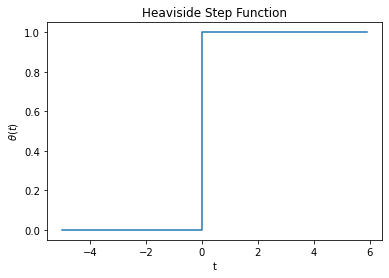

In [120]:
t = np.arange(-5,6,0.1)
fig,ax = plt.subplots()

ax.step(t,np.heaviside(t,1))
    
ax.set_xlabel('t')
ax.set_ylabel('$\\theta(t)$')
ax.set_title('Heaviside Step Function')

That seems rather unexciting, however, if we substract another instance of this function that has been shifted say, by 3 units on the x-axis, we get;

Text(0.5, 1.0, 'Two Heaviside Step Functions combined')

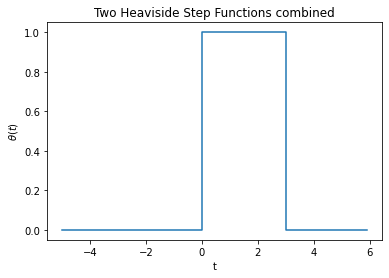

In [121]:
t = np.arange(-5,6,0.1)
fig,ax = plt.subplots()

ax.step(t,np.heaviside(t,1)-np.heaviside(t-3,1))
    
ax.set_xlabel('t')
ax.set_ylabel('$\\theta(t)$')
ax.set_title('Two Heaviside Step Functions combined')



Ok, while you haven't fallen asleep already, we can add and subtract a bunch of these shifted instances of the Heaviside function and get all sorts of crazy stairs and step looking reults.



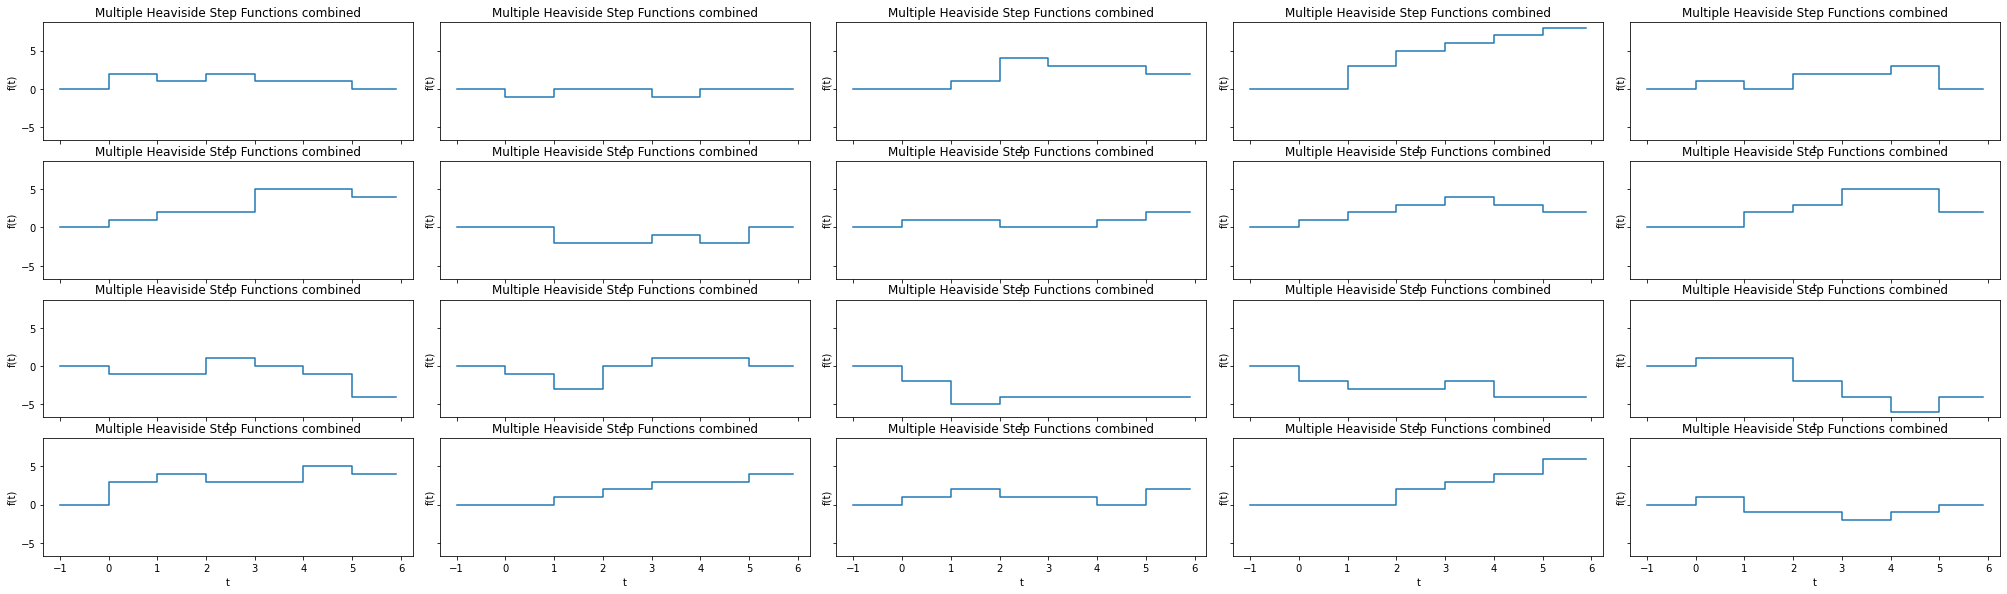

In [164]:
def generate_step_func(samples, x_vals):
    hfuncs = np.zeros(len(x_vals))

    for i in range(samples):
        signs = random.choice([-1,1])
        shifts = random.randint(0,5)
        hfuncs += signs*np.heaviside(x_vals-shifts,1)
        
    return hfuncs
    

t = np.arange(-1,6,0.1)
fig,axs = plt.subplots(nrows=4, ncols=5,figsize=(28,8),sharey=True, sharex=True)


plt.tight_layout()

for i,ax in np.ndenumerate(axs):
    func_data = generate_step_func(10, t)
    ax.step(t,func_data)
    ax.set_xlabel('t')
    ax.set_title('Multiple Heaviside Step Functions combined')
    ax.set_ylabel('f(t)')



From the sample charts generated above, it can be observed that the ability produce a step function of any level of complexity by forming linear combinations of Heaviside functions is fairly simple and easy to understand. By using the Heaviside function as a basis that any combination of up and down steps, which occur at any time can be defined mathematically. By putting the data into this format, we can perform analysis, modifications and modelling with ease by using the rules of linear algebra.

Now for the question that means the most, why would we want to be able to use linear algebra techniques for our data? 

Let's take an example of where some of this formulation can be helpful. Consider if we have two datasets of low value count data, something simple like the arrival and departure times for each customer for two checkouts in a supermarket over for each hour during business hours. Since only whole customers (hopefully) arrive in the queue, get processed and they leave the queue, the data is discrete and the counts are integer. Also, we are looking at a typical scenario where the values are not very large, typically a maximum of 5 people in a queue, as any new customer will probably look for another queue to join.

The data is contained in the checkout.csv example file, let's get cracking.

In [173]:
dfcheckouts = pd.read_csv(r"data/checkout.csv", parse_dates=['start', 'end'], dayfirst=True)
dfcheckouts.start = dfcheckouts.start.apply(pd.Timestamp)
dfcheckouts.end = dfcheckouts.end.apply(pd.Timestamp)

dfcheckouts.head()

,queue,start,end
0,COUT1,2020-01-01 00:06:00,2020-01-01 00:13:00
1,COUT2,2020-01-01 00:50:00,2020-01-01 00:59:00
2,COUT1,2020-01-01 00:54:00,2020-01-01 00:57:00
3,COUT2,2020-01-01 02:14:00,2020-01-01 02:19:00
4,COUT1,2020-01-01 02:29:00,2020-01-01 02:32:00


Normally with data like this, we would have to count up the number of overlaps in the start and end times for each queue to build a picture of what the queue length is over time, since all we have is the +1 when a customer starts in the queue and a -1 when the customer ends in the queue. Using the Hotstepper library, we can quickly import this data and get a look at the details, as this is part of what Hotstepper is all about, just getting on with the job of understanding, analysing and modelling the data without needing to twist and turn to get anywhere.

Ok, so let's have a visual look at the data for each queue over timespan of the data to get a feel for what we have.

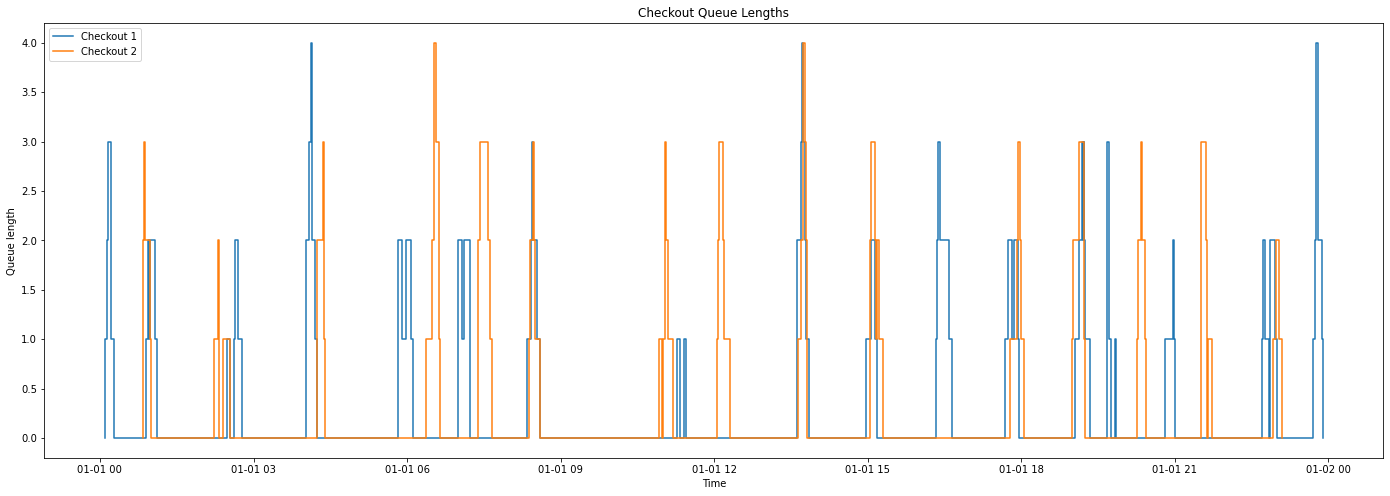

In [177]:
fig,ax = plt.subplots(figsize=(24,8))

cout1_queue = Steps.stepify(dfcheckouts[dfcheckouts.queue=='COUT1'],'start','end')
cout2_queue = Steps.stepify(dfcheckouts[dfcheckouts.queue=='COUT2'],'start','end')

cout1_queue.plot(ax=ax,label='Checkout 1')
cout2_queue.plot(ax=ax,label='Checkout 2')

ax.set_xlabel('Time')
ax.set_title('Checkout Queue Lengths')
ax.set_ylabel('Queue length')
ax.legend()

So this looks interesting, ok, so just a bunch of spikes, we can ask some questions now though, like what is the average queue length across this day for each checkout.


In [183]:
print(f'Average queue length for checkout 1 across the day is: {cout1_queue.mean():.2f}, with std: {np.sqrt(cout1_queue.var()):.2f}')
print(f'Average queue length for checkout 2 across the day is: {cout2_queue.mean():.2f}, with std: {np.sqrt(cout2_queue.var()):.2f}')

Average queue length for checkout 1 across the day is: 0.26, with std: 0.67
Average queue length for checkout 2 across the day is: 0.27, with std: 0.72
